code for descriptive analysis on WARP data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


# Third party packages.
import os                       # Execute tasks related to your operating system.

# import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib
from pathlib import Path
import logging
import json
import sqlite3

# from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('To fetch data from database and save as csv')

CONFIG_PATH = "/Users/sgawde/work/eaisi-code/main-branch-11-may/ENEXIS/workspaces/sandeep/config/config.json"

# === CONFIG ===

with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

MODEL_RUN_RESULTS_DIR = config['ned']['ned_model_download_dir']

# Connect to the SQLite database
db_path = '/Users/sgawde/work/eaisi-code/main-branch-21may/ENEXIS/src/data/WARP.db'
conn = sqlite3.connect(db_path)
# Connect to the SQLite database using the existing db_path
conn = sqlite3.connect(db_path)
# Step 2: Read data from table
df_pd_orig = pd.read_sql_query("SELECT * FROM master_warp ORDER BY target_datetime DESC", conn)

# Step 3: Close the connection
conn.close()

logger = logging.getLogger('Database fetch complete')


To draw line graph

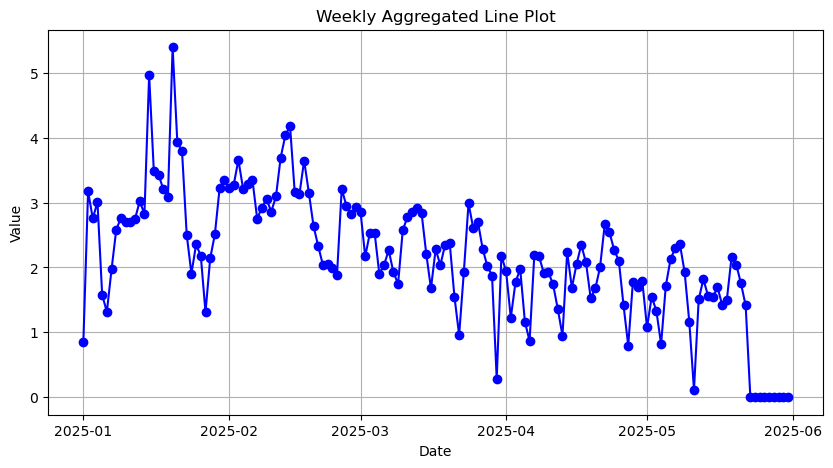

In [3]:
# Convert hr column to datetime (if not already)
df_pd_orig['target_datetime'] = pd.to_datetime(df_pd_orig['target_datetime'])

# Filter for the specified periodetime(df['target_datetime'])
mask = (df_pd_orig['target_datetime'] >= '2025-01-01') & (df_pd_orig['target_datetime'] <= '2025-05-15')
df_period = df_pd_orig.loc[mask]

# Resample by day and aggregate (e.g., taking the sum or mean)
df_daily = df_pd_orig.resample('D', on='target_datetime').sum()  # You can use .mean(), .max(), etc.
# Extract only the day part
# print(df_daily.head(3))
df_daily['day'] = df_pd_orig['target_datetime'].dt.day

plt.figure(figsize=(10, 5))
plt.plot(df_daily.index, df_daily['Price'], marker='o', linestyle='-', label='Price', color='b')


# Labels and Title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Weekly Aggregated Line Plot")
plt.grid()

plt.show()


Descriptive Statistics

In [4]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 19 numerical variables:
Index(['Price', 'Load', 'shortwave_radiation', 'temperature_2m',
       'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO',
       'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin',
       'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover',
       'weekday_sin', 'hour_sin', 'weekday_cos'],
      dtype='object')
Number of rows: 3624 and column names are: Index([], dtype='object') and column types are: Series([], dtype: object)


To check if the output column has unique values

In [5]:
l_col = ['Price']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Price']:         Price
0     0.00000
1     0.00000
2     0.00000
3     0.00000
4     0.00000
...       ...
3619  0.00068
3620  0.00328
3621  0.00416
3622  0.00624
3623  0.01362

[3624 rows x 1 columns]
Price: [0.      0.10852 0.1242  ... 0.00328 0.00416 0.00624]


Contruct a descriptive summary

In [6]:
df_pd_orig.describe()

,Price,Load,shortwave_radiation,temperature_2m,direct_normal_irradiance,diffuse_radiation,Flow_NO,yearday_cos,Flow_GB,month,is_dst,yearday_sin,is_non_working_day,hour_cos,is_weekend,cloud_cover,weekday_sin,hour_sin,weekday_cos
count,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3.624000e+03,3624.000000,3624.000000,3.624000e+03,3.624000e+03,3624.000000
mean,0.090612,11714.090117,108.625276,5.943191,127.032884,39.148499,278.998620,0.193108,-182.305533,3.013245,0.416943,0.716069,0.311258,-5.330541e-17,0.284768,23.878587,-3.921318e-18,-2.058692e-17,-0.014881
std,0.058050,4691.901831,215.547187,6.858669,246.201846,69.095531,315.218635,0.613750,618.798221,1.423683,0.493121,0.270904,0.463072,7.072044e-01,0.451366,39.379526,7.085027e-01,7.072044e-01,0.705747
min,-0.350000,0.000000,0.000000,-4.200000,0.000000,0.000000,-650.000000,-0.855631,-1101.000000,1.000000,0.000000,0.017202,0.000000,-1.000000e+00,0.000000,0.000000,-9.749279e-01,-1.000000e+00,-0.900969
25%,0.068000,10506.750000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.380447,-796.062500,2.000000,0.000000,0.561034,0.000000,-7.071068e-01,0.000000,0.000000,-7.818315e-01,-7.071068e-01,-0.900969
50%,0.098260,12668.875000,0.000000,2.832500,0.000000,0.000000,302.500000,0.260376,0.000000,3.000000,0.000000,0.797102,0.000000,-6.123234e-17,0.000000,0.000000,0.000000e+00,6.123234e-17,-0.222521
75%,0.125022,14646.125000,70.000000,11.236875,54.314417,54.931069,620.000000,0.793844,98.875000,4.000000,1.000000,0.948772,1.000000,7.071068e-01,1.000000,37.250000,7.818315e-01,7.071068e-01,0.623490
max,0.523470,19483.250000,875.000000,27.882500,818.356445,338.489990,621.000000,0.999852,1070.000000,5.000000,1.000000,0.999986,1.000000,1.000000e+00,1.000000,100.000000,9.749279e-01,1.000000e+00,1.000000


To plot corelation matrix

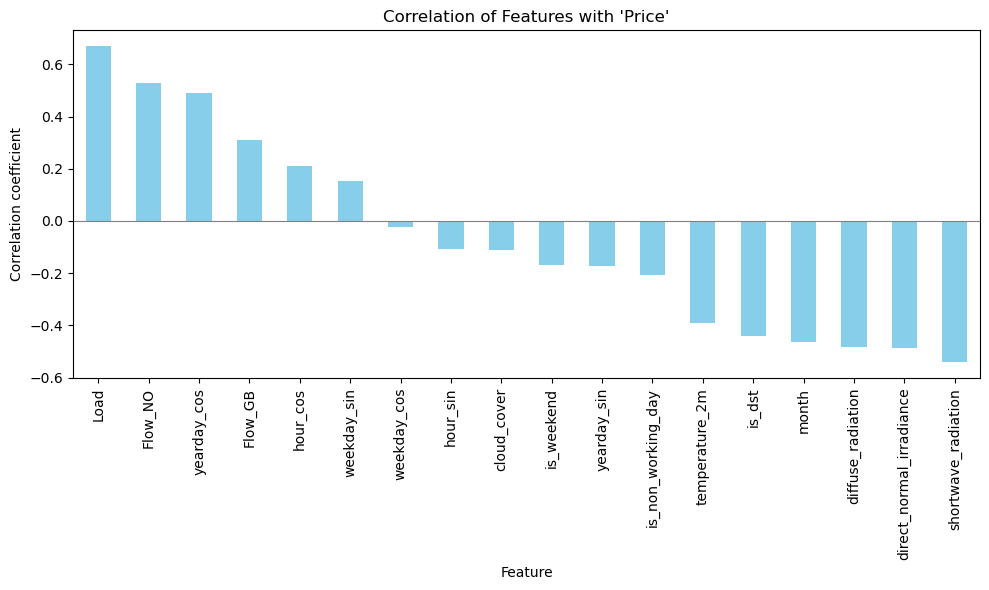

,Feature,Correlation with Price,Abs Correlation
0,Load,0.669825,0.669825
1,shortwave_radiation,-0.541677,0.541677
5,Flow_NO,0.529140,0.529140
6,yearday_cos,0.489370,0.489370
3,direct_normal_irradiance,-0.485626,0.485626
4,diffuse_radiation,-0.482948,0.482948
8,month,-0.463525,0.463525
9,is_dst,-0.440473,0.440473
2,temperature_2m,-0.391387,0.391387
7,Flow_GB,0.311701,0.311701



Updated DataFrame shape (only 'Price' and highly correlated features):
(3624, 19)


In [7]:
# Compute correlation of 'Price' with all other numeric columns
price_corr = df_pd_num.corr()['Price'].drop('Price')

# Plot bar chart of correlations with 'Price'
plt.figure(figsize=(10, 6))
price_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with 'Price'")
plt.ylabel('Correlation coefficient')
plt.xlabel('Feature')
plt.axhline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

# Display correlation values as a table
corr_table = price_corr.reset_index()
corr_table.columns = ['Feature', 'Correlation with Price']
# Add absolute correlation column
corr_table['Abs Correlation'] = corr_table['Correlation with Price'].abs()
corr_table = corr_table.sort_values(by='Abs Correlation', ascending=False)
corr_table.style.highlight_max(subset='Abs Correlation', color='lightgreen')
display(corr_table)

# Identify columns with low correlation to 'Price' (between -0.25 and 0.25)
#columns_to_remove = price_corr[(price_corr >= -0.25) & (price_corr <= 0.25)].index.tolist()
#print("Columns removed due to low correlation with 'Price' (between -0.25 and 0.25):")
#print(columns_to_remove)

# Filter DataFrame to keep only 'Price' and highly correlated features
#selected_features = ['Price'] + [col for col in price_corr.index if col not in columns_to_remove]
selected_features = ['Price'] + [col for col in price_corr.index]
df_filtered_price = df_pd_num[selected_features]
print("\nUpdated DataFrame shape (only 'Price' and highly correlated features):")
print(df_filtered_price.shape)


Limited Features consideration

In [8]:
# Identify columns with low correlation to 'Price' (between -0.25 and 0.25)
columns_to_remove = price_corr[(price_corr >= -0.25) & (price_corr <= 0.25)].index.tolist()
print("Columns removed due to low correlation with 'Price' (between -0.25 and 0.25):")
print(columns_to_remove)

# Filter DataFrame to keep only 'Price' and highly correlated features
selected_features = ['Price'] + [col for col in price_corr.index if col not in columns_to_remove]
df_filtered_price = df_pd_num[selected_features]
print("\nUpdated DataFrame shape (only 'Price' and highly correlated features):")
print(df_filtered_price.shape)

Columns removed due to low correlation with 'Price' (between -0.25 and 0.25):
['yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday_cos']

Updated DataFrame shape (only 'Price' and highly correlated features):
(3624, 11)


/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_11427/1313634106.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


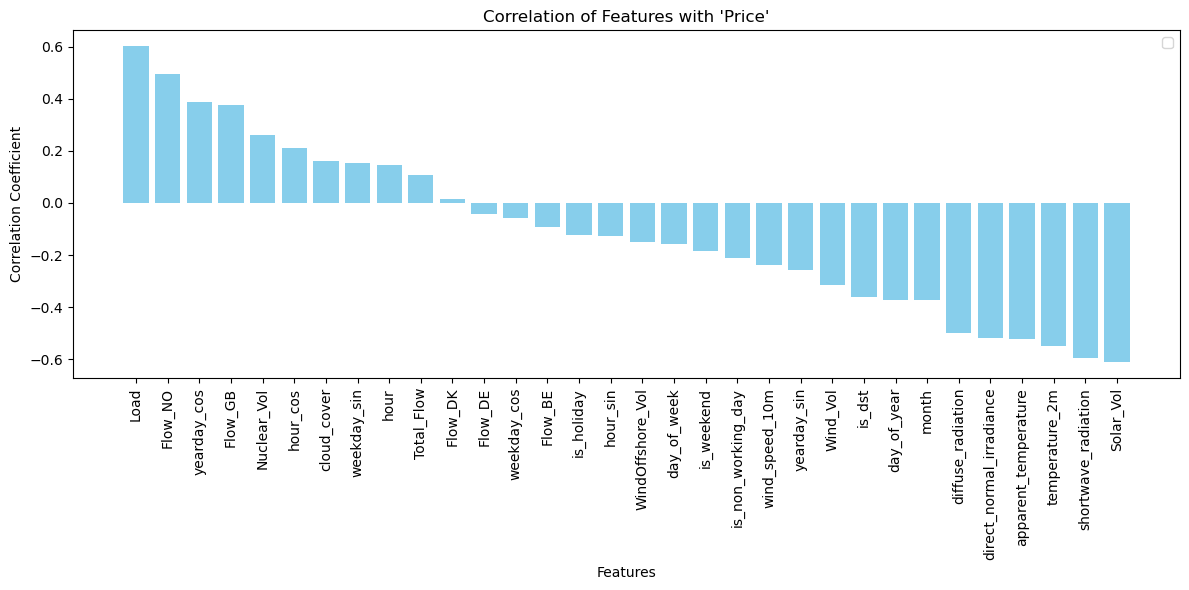

,Features,Correlation,AbsCorrelation
1,Load,0.601835,0.601835
7,Flow_NO,0.494983,0.494983
8,yearday_cos,0.389194,0.389194
9,Flow_GB,0.375704,0.375704
18,hour_cos,0.209432,0.209432
20,cloud_cover,0.161850,0.161850
22,weekday_sin,0.154629,0.154629
29,weekday_cos,-0.059683,0.059683
25,hour_sin,-0.127918,0.127918
19,is_weekend,-0.185789,0.185789


In [10]:


# Load API Key and download directory from config file
FEATURES_CSV_FILE = "../data/feature-selection.csv"

features_df = pd.read_csv(FEATURES_CSV_FILE)

# Sort by absolute correlation (ascending for visual clarity)
features_df_sorted = features_df.sort_values(by="Correlation", ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(features_df_sorted["Features"], features_df_sorted["Correlation"], color='skyblue')
plt.title("Correlation of Features with 'Price'")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=90)
#plt.axhline(0.25, color='red', linestyle='--', linewidth=1, label='Low correlation threshold (±0.25)')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Display top N features
# Filter rows where 'keep' == 'Y'
filtered_table = features_df_sorted[features_df_sorted["keep"] == "Y"]

# Exclude 'keep' column from display
filtered_table = filtered_table[["Features", "Correlation", "AbsCorrelation"]]

# Display the filtered table
display(filtered_table)

